<br><h2 align="Center"> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="60" width="200" align="Center" />MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II</h2>
<h2 align="Center">
Presentado por:<br>
Fabián Cholo Acevedo - Cód 201523509<br>
Jaime Orjuela Viracacha - Cód 201924252<br>
</h2>

# Micro-Proyecto 2

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.

Nombres:


### Introducción
Una aplicación de música quiere actualizar su aplicación online para que genere recomendaciones a sus usuarios de nuevos artistas para escuchar. El sistema de recomendación debe tomar en cuenta las preferencias de cada usuario, con el fin de ofrecer recomendaciones automáticas y personalizadas.

La base de datos que va a trabajar se ha tomado de http://ocelma.net/MusicRecommendationDataset/lastfm-360K.html


### Enunciado 1
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un algoritmo de recomendación de artistas para cada usuario. Implemente el algoritmo a partir del conjunto de datos: "lastfm-dataset-360K/usersha1-profile.tsv" y evalúe su desempeño con respecto a la métrica apropiada.

### Enunciado 2
Una vez a desarrollado su primer sistema de recomendación, intente mejorarlo con respecto a la métrica de su elección, considerando además la información que encuentra en "lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv", donde encuentra información de tipo socio-demográfico por usuario.

## **1. Analisis de Datos**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


Se importa el archivo de datos y se encuentra que de los 17.559.530 registros, algunos de ellos tienen información por fuera del formato establecido en el archivo README de la fuente, se realiza entonces una limpieza desde shell script (linea de comandos de la terminal) de los datos quedando con 17.328.427

`
$awk -F\t 'NF==4 && $2~/\-/ && length($1)==40' usersha1-artmbid-artname-plays.tsv > users_artist_played.tsv
`

Se encontró adicionalmente que muchos de los artistas era muy poco escuchados y generaban exceso de datos, por lo que se decidió agrupar por artist_id y seleccionar aquellos que tuvieran más de 300 reproducciones.  Esa información quedó cargada en el archivo plano `tabla4.csv` que tiene 13.866.515 registros.

In [2]:
# leemos el archivo con columnas user/artist/plays
data = pd.read_csv("tabla4.csv", sep='\|', engine='python', skiprows=0,
                    usecols=[0, 1, 2, 3], 
                    names=['user', 'artist_id', 'artist', 'plays'])

# map each artist and user to a unique numeric value
data['user'] = data['user'].astype("category")
data['artist'] = data['artist'].astype("category")
data['artist_id'] = data['artist_id'].astype("category")
data['plays'] = data['plays'].astype("int32")

In [3]:
data.shape

(13866515, 4)

In [4]:
print(data[['user', 'artist_id']].nunique())

user         359116
artist_id      7429
dtype: int64


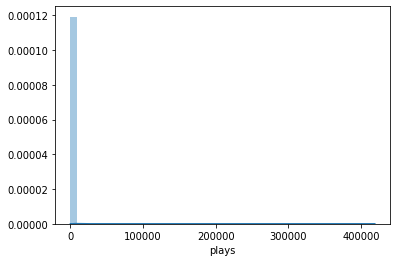

In [5]:
sns.distplot(data['plays'])

In [6]:
data.describe()

,plays
count,1.386652e+07
mean,2.302858e+02
std,6.574876e+02
min,0.000000e+00
25%,3.900000e+01
50%,1.020000e+02
75%,2.390000e+02
max,4.191570e+05


Considerando que se encuentran valores extremos, para evitar el sesgo debido a esos datos se quitan las colas extremas del 1% arriba y del 10% abajo.

In [7]:
# Considerando que se encuentran valores extremos, para evitar el sesgo debido a esos datos
# se quitan las colas extremas del 10% arriba y del 1% abajo.
q1 = data['plays'].quantile(0.1)
q99 = data['plays'].quantile(0.99)

# Filtro por Quantil
data_q = data[(data.plays>=q1) & (data.plays<=q99)].copy()

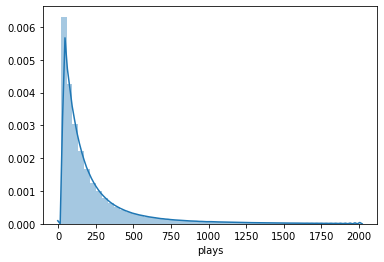

In [9]:
sns.distplot(data_q['plays'])

In [21]:
# Calculate the number of unique values
print(data_q[['user', 'artist_id']].nunique())

user         350978
artist_id      7428
dtype: int64


Hay 350.978 usuarios y 7.428 artistas (id de artista), pero teniendo en cuenta el volumen de los datos y las limitaciones existentes de máquina, se extrae una porción (10%) para los análisis, quedando con 1.236.271

In [11]:
data_train, data_test= train_test_split(data_q, test_size=0.1, random_state=4)

In [13]:
data_test.shape

(1236271, 4)

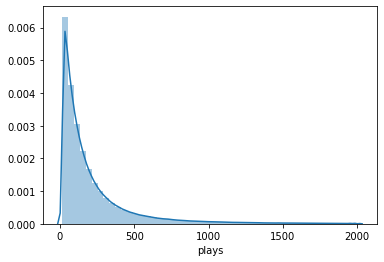

In [14]:
# Calculate the number of unique values
sns.distplot(data_test['plays'])

Se ve que el conjunto de datos resultante conserva la distribución del conjunto inicial.

In [22]:
print(data_test[['user', 'artist_id']].nunique())

user         322851
artist_id      7428
dtype: int64


Finalmente se consideran en el análisis 322.851 usuarios y 7.428 artistas.

# Metodología propuesta

Entre las estrategias más usadas para crear sistemas de recomendación se encuentran (tomado de: <a href="https://www.aprendemachinelearning.com/sistemas-de-recomendacion/">https://www.aprendemachinelearning.com/sistemas-de-recomendacion/</a>):

<ul>
    <li><strong>Por popularidad:</strong> Aconseja por la “popularidad” de los productos. Por ejemplo, “los más vendidos” globalmente, se ofrecerán a todos los usuarios por igual sin aprovechar la personalización. Es fácil de implementar y en algunos casos es efectiva.</li>
    <li><strong>Basado en el contenido:</strong> A partir de productos visitados por el usuario, se intenta “adivinar” qué busca el usuario y ofrecer mercancías similares.</li>
    <li><strong>Filtrado colaborativo:</strong> Es el más novedoso, pues utiliza la información de “masas” para identificar perfiles similares y aprender de los datos para recomendar productos de manera individual.</li>
</ul>

Teniendo en cuenta los datos disponibles en la base de datos del caso de análisis, se tiene acceso únicamente a información implícita, es decir que no se posee información de realimentación directa de los usuarios (si les gustó o no cada artista) sino la cantidad de reproducciones que cada usuario hizo para cada artista, se asume entonces que si un usuario escuchó con mayor frecuencia a un artista implica que ese artista es de su preferencia.

## Recomendación por popularidad

Inicialmente se realizaron las recomendaciones buscando la pareja más popular para cada artista. Se emparejó entonces cada artista con los demás escuchados por la misma persona y luego se contaron cuántas veces esa pareja estaba en el conjunto de datos. Se creó así una tabla de referencia que permitió determinar para cada artista su pareja más popular, partiendo del supuesto que si a una persona le gusta un artista, lo más probable es que también le guste su pareja más popular.

In [17]:
from itertools import permutations

# Se crea la función que encuentra las parejas para cada artista
def find_artist_pairs(x):
    
    pairs = pd.DataFrame(list(permutations(x.values, 2)),
                       columns=['artist_a', 'artist_b'])
    return pairs

In [18]:
# Crea un data set con las combinaciones para cada artista 
artist_combinations = data_test.groupby('user')['artist'].apply(
  find_artist_pairs).reset_index(drop=True)

print(artist_combinations)

                  artist_a          artist_b
0         walls of jericho         rasputina
1                rasputina  walls of jericho
2        animal collective           nujabes
3        animal collective       the strokes
4        animal collective   the microphones
...                    ...               ...
4851035              epica       lamb of god
4851036        iron maiden             epica
4851037        iron maiden       lamb of god
4851038        lamb of god             epica
4851039        lamb of god       iron maiden

[4851040 rows x 2 columns]


Se evidencia que aún con el 10% de los datos (1.548.282), el numero de combinaciones resultantes es de 4.851.040; por lo que realizar este proceso para todo el conjunto de datos (13.866.515) requeriría unas capacidades computacionales muy altas que no poseemos.  No obstante, buscando alternativas de desarrollo, se intentó realizar este emparejamiento en una Base de Datos MySQL, creando índices en el campo de usuario y artista, y realizando análisis segmentados mediante cursores, es decir que se accedía primero a la información del índice y luego se cargaba un buffer en memoria RAM sólo con la porción de la tabla que se requería, lo que funcionó a nivel de máquina pues no se bloqueó, sin embargo al consultar la información del QUERY EXPLAIN PLAN, había tantas iteraciones que implicaba un tiempo de procesamiento de muchas horas, por lo que también claudicamos en ese intento.  

Teniendo en cuenta lo anterior, continuamos el análisis en python con el conjunto de datos de prueba `data_test`, para lo cual se realizó un conteo por `artista_a` y por `artista_b`, para determinar de entre las parejas encontradas para el `artista_a`, cual era 
la más popular para los oyentes.

In [23]:
# se cuenta la cantidad de veces que aparece en todo el conjunto cada pareja
combination_counts = artist_combinations.groupby(['artist_a', 'artist_b']).size()

# Convierte los resultados a un data frame y restaura el índice
combination_counts_df = combination_counts.to_frame(name='size').reset_index()
print(combination_counts_df)

                   artist_a             artist_b  size
0                       !!!  "weird al" yankovic     1
1                       !!!                  +/-     1
2                       !!!             13 & god     1
3                       !!!          2 many dj's     2
4                       !!!   30 seconds to mars     1
...                     ...                  ...   ...
2649498  �������� ���������         guns n roses     1
2649499  �������� ���������                 ko?n     1
2649500  �������� ���������       massive attack     1
2649501  �������� ���������              rainbow     1
2649502  �������� ���������                unkle     1

[2649503 rows x 3 columns]


Se llevó a un archivo plano, para facilitar la extracción de la pareja más popular en MySQL. <strong>NOTA:</strong> los artistas registrados en la base de datos con caracteres orientales, aparecen con signos de interrogación.

In [ ]:
combination_counts_df.to_csv('combinations_counts.csv', index = False)

<p font-family: "Courier New">

    CREATE PROCEDURE insert_recommendations_lookup()
    
    DECLARE v_artist_id VARCHAR(90);
    DECLARE v_cuenta INT;
    DECLARE v_finished BOOLEAN DEFAULT FALSE;
    DECLARE  c CURSOR FOR SELECT artist_ida, cuenta FROM artistas;
    DECLARE CONTINUE HANDLER FOR NOT FOUND SET v_finished = TRUE;
    
    OPEN c;
    bucle: LOOP
		FETCH c INTO v_artist_id, v_cuenta;
        IF v_finished THEN
			leave bucle;
		END IF;
		
        INSERT INTO recommendations_lookup
        SELECT * 
        FROM parejas_artistas 
		WHERE artist_ida = v_artist_id
			AND cuenta = v_cuenta
		LIMIT 1;
 
    END LOOP bucle;
    CLOSE c;
    
</p>

Se obtuvo entonces el archivo `recommendations_lookup.csv` el cual contiene para cada artista, un nuevo recomendado basado en el historial de reproducciones.

In [19]:
recommendations_lookup = pd.read_csv('recommendations_lookup1.csv', sep='\;', engine='python')

In [20]:
recommendations_lookup

,artist_ida,artist_idb,cuenta
0,_algol_,abnocto,1
1,_soundtrack,"""andrew bird""",1
2,"""- m -""",air,1
3,"""-123 min.""",queen,2
4,-elettronoir-,"""antony and the johnsons""",1
...,...,...,...
78981,黒石ひとみ,news,1
78982,黒薔薇保存会,akb48,1
78983,鼓太蝋,arm,1
78984,齊豫,"""eric clapton""",1


De los 7.429 artistas analizados, se obtuvieron 78.986 recomendaciones.  Para este método no usamos una métrica de bondad de ajuste, ya que corresponde al método de popularidad.

## Filtrado Colaborativo

### **Contruccion de Matrices**

Para el desarrollo del filtrado Colaborativo, en lugar de tomar una muestra del conjunto total, se eligió como criterio de reducción el atributo de país, y se escogió a Colombia para aplicar este método después de probar con diferentes tamaños de muestra y de encontrar que no eran adecuados para este método dado que no se contaba con el nivel de detalle requerido. 

In [24]:
data_train, data_test = train_test_split(data_q, test_size=0.05, random_state=42)

In [25]:
# leemos el archivo con columnas user/artist/plays
data = pd.read_csv("join_colombia1.psv", sep='\|', engine='python', skiprows=1,
                    names=['user', 'artist_id', 'plays','gender','age','country','signup'])

# map each artist and user to a unique numeric value
data['user'] = data['user'].astype("category")
data['artist_id'] = data['artist_id'].astype("category")
data['gender'] = data['gender'].astype("category")
data['plays'] = data['plays'].astype("int32")
data['age'] = data['age'].astype("int32")

In [26]:
data.shape

(71230, 7)

In [27]:
print(data[['user', 'artist_id']].nunique())

user         1849
artist_id    5556
dtype: int64


De los 71.230 registros para colombia, hay 1849 usuarios y 5556 artistas, en este punto identificamos que el gran número de artistas dificulta construir una recomendación adecuada dada la diversidad de información.

In [28]:
# Transform the table
user_ratings_table = data.pivot(index='user', columns='artist_id', values='plays').fillna(0)
# Inspect the transformed table
user_ratings_table.head(3)

artist_id,00034ede-a1f1-4219-be39-02f36853373e,000b1990-4dd8-4835-abcd-bb6038c13ac7,000fc734-b7e1-4a01-92d1-f544261b43f5,000fecd9-ae03-49bc-9a08-636dde5d405d,0019749d-ee29-4a5f-ab17-6bfa11deb969,0031bc7a-1b6f-4620-99db-5202405b0749,00370693-7679-46c1-8ddd-63e1d082c459,00376321-ce0f-4bd7-a98f-fcabdbf06ea7,0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,004e5eed-e267-46ea-b504-54526f1f377d,...,ffb390b8-8df4-4b72-97d1-7b2fc008a452,ffba0d4b-a2bd-46d1-98e0-bf7d08ae8744,ffbfc446-f717-4c63-9103-587defe6cf8a,ffce4003-a756-46c0-b062-2e942de13d37,ffd3ac37-4d0a-42a1-a41e-e160cf60dca5,ffdf7f27-a12c-40fe-8ae3-050b46fc2f79,ffe02aed-ef7e-4736-a186-c2f1dd55ce8d,ffe16bba-4d84-409b-8f22-5242c60b930f,ffe53025-23f7-4c80-ac9d-442a3275d4a6,ffe9ec08-6b6b-4993-9394-e280b429dbfd
user,,,,,,,,,,,,,,,,,,,,,
00924eef9c4f03910db826ed8f314f69c1820471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,220.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00b5066cacdebe242a200fb4df30203eaac57ce7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00b5c063374ca2de9111b4bc95ea349db3c551b7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
user_ratings_table.shape

(1849, 5556)

### **Sparcity**

Veamos el porcentaje de sparcity que tenemos:

Teniendo en cuenta la alta dispersión de los datos, se usa la siguiente métrica para determinarsi el filtrado colaborativo es el más adecuado para recomendar, aún cuando pocos usuarios han valorado los mismos productos:

In [30]:
#“ceros” que rellenar (predecir)…
ratings = user_ratings_table.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.69%


**Train y Test set**

Separamos en train y test para -más adelante- poder medir la calidad de nuestras recomendaciones.

In [31]:
ratings_train, ratings_test = train_test_split(user_ratings_table, test_size = 0.2, random_state=42)
print(ratings_train.shape)
print(ratings_test.shape)

(1479, 5556)
(370, 5556)


**Matriz de Similitud: Distancias por Coseno**

Ahora calculamos en una nueva matriz la similitud entre usuarios.

In [32]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(user_ratings_table)
print(sim_matrix.shape)

(1849, 1849)


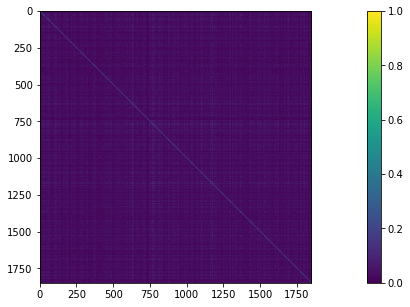

In [36]:
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

#Cuanto más cercano a 1, mayor similitud entre esos usuarios, en este caso no se evidencia similitud. 

### **Predicciones**

In [34]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:1479,0:1479]
sim_matrix_test = sim_matrix[1479:1849,1479:1849]

users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

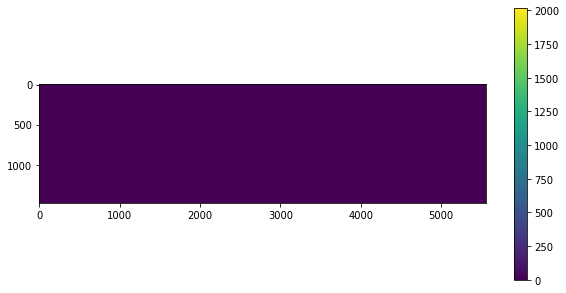

In [40]:
#Graficar la solucion
# plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

Al graficar la solución para el conjunto de datos escogido, se identifica que no se obtienen predicciones dada la alta dispersión del conjunto de datos analizado. Lo cual nos impidió calcular la métrica de desempeño escogida en este caso RMSE.

In [37]:
def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [ ]:
users_predictions

In [ ]:
users_predictions_test

In [ ]:
get_mse(users_predictions_test, ratings_test)


# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[1479:1849,:]

get_mse(users_predictions_test, ratings_test)

Objetivo General:

Una aplicación de música quiere actualizar su aplicación online para generar recomendaciones a sus usuarios de nuevos artistas para escuchar.

como consultores externos se analiza la informacion recibida y se decide implementar la solucion usando motores de recomedación.

Especificos:

Desarrollar un algoritmo de recomendación de artistas para cada usuario y evaluar su desempeño. 

Para llevar a cabo este requerimiento, se implmento el metodo de Popularidad, mediante el cual se recomienda a los usuarios “los artistas más escuchados” globalmente, bajo esta premisa se calculan las parejas más populares y se ofrecen a todos los usuarios por igual sin tener en cuenta la informacion demografica. 

Mejorar el algoritmo considerando la información de tipo socio-demográfico por usuario
 
Para llevar a cabo este requerimiento, se implementó el método de filtrado colaborativo, el cual utiliza la información para identificar perfiles similares y aprender de los datos para recomendar artistas de manera individual. En la primera fase se usó toda la información disponible, pero la capacidad de cómputo requerida impidio procesar la informacion, y se plantearon las siguientes estrategias: segmentar por muestreo o por pais, escogiendo a Colombia por afinidad y conocimiento de los datos y realizar una muestra aleatoria a nivel global la cual dada su heterogenidad no permitio correr los algoritmos. 

Teniendo en cuenta el gran volumen de los datos, se puede buscar otras herramientas computacionales diversas diferentes as python, como lo son el shell script de Linux o MacOS, Bases de datos entre otros.

